# Active Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

## The Dataset

In [2]:
# load the data
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


## pool-based Active Learning

In [19]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

def RunAL(estimator, ref_model, X_train, y_train, query_strategy, n_queries, n_initial):
    # initialization
    np.random.seed(0)
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
    X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    random_X_pool, random_y_pool = X_pool.copy(), y_pool.copy()
    # create instance
    learner = ActiveLearner(
        estimator=estimator,
        query_strategy=query_strategy,
        X_training=X_initial, y_training=y_initial
    )
    random_learner = ActiveLearner(
        estimator=estimator,
        query_strategy=random_sampling,
        X_training=X_initial, y_training=y_initial
    )
    
    # training process
    train_accuracy = [learner.score(X_train, y_train)]
    test_accuracy = [learner.score(X_test, y_test)]
    random_train_accuracy = [random_learner.score(X_train, y_train)]
    random_test_accuracy = [random_learner.score(X_test, y_test)]
    ref_model.fit(X_train, y_train)
    train_reference = ref_model.score(X_train, y_train)
    test_reference = ref_model.score(X_test, y_test)
    for i in range(n_queries):
        # Active Learning
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1, ))
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        train_accuracy.append(learner.score(X_train, y_train))
        test_accuracy.append(learner.score(X_test, y_test))
        # Random Learning
        random_query_idx, _ = random_learner.query(random_X_pool)
        random_learner.teach(random_X_pool[random_query_idx].reshape(1, -1), random_y_pool[random_query_idx].reshape(1, ))
        random_X_pool, random_y_pool = np.delete(random_X_pool, random_query_idx, axis=0), np.delete(random_y_pool, random_query_idx, axis=0)
        random_train_accuracy.append(random_learner.score(X_train, y_train))
        random_test_accuracy.append(random_learner.score(X_test, y_test))

    # merge result
    result = {"train_accuracy": train_accuracy, "test_accuracy": test_accuracy,\
        "random_train_accuracy": random_train_accuracy, "random_test_accuracy": random_test_accuracy, \
            "train_reference": train_reference, "test_reference": test_reference}
    return result

def PlotLearningCurve(n_queries, accuracy):
    # plot learning curve
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.title('Accuracy of the classifier during the active learning')
        plt.plot(range(n_queries+1), accuracy["train_accuracy"])
        plt.scatter(range(n_queries+1), accuracy["train_accuracy"])
        plt.plot(range(n_queries+1), accuracy["test_accuracy"])
        plt.scatter(range(n_queries+1), accuracy["test_accuracy"])
        plt.plot(range(n_queries+1), accuracy["random_train_accuracy"], '--', color="lightblue", alpha=0.5)
        plt.scatter(range(n_queries+1), accuracy["random_train_accuracy"], color="lightblue", alpha=0.5)
        plt.plot(range(n_queries+1), accuracy["random_test_accuracy"], '--', color="bisque", alpha=0.5)
        plt.scatter(range(n_queries+1), accuracy["random_test_accuracy"], color="bisque", alpha=0.5)
        plt.axhline(y=accuracy["train_reference"], color="midnightblue", linestyle=':')
        plt.axhline(y=accuracy["test_reference"], color="chocolate", linestyle=':')
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        plt.legend(["train accuracy", "test accuracy", \
            "random train accuracy", "random test accuracy",\
            "train reference", "test reference"])
        plt.show()


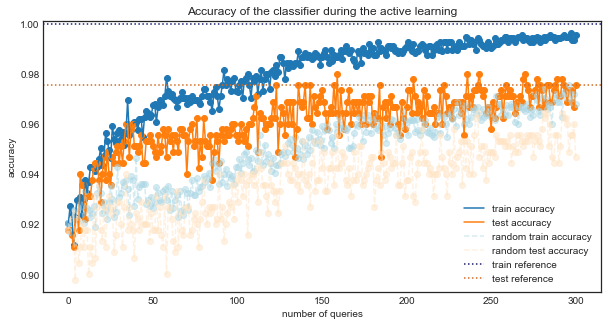

In [25]:
n_initial = 200
n_queries = 300
estimator = RandomForestClassifier()
ref_model = RandomForestClassifier()
query_strategy = margin_sampling
accuracy = RunAL(estimator, ref_model, X_train, y_train, query_strategy, n_queries, n_initial)
PlotLearningCurve(n_queries, accuracy)